Device set to use cpu


=== Chatbot Started ===
Type 'exit' or 'bye' to end the chat.

User: hello
→ Sentiment: Positive (score: 1.00)
Chatbot: Hello! How can I help you today?
User: "Your service disappoints me"
→ Sentiment: Negative (score: 1.00)
Chatbot: Thanks for sharing that. Tell me more.
User: "I’ll make sure your concern is addressed."
→ Sentiment: Positive (score: 0.98)
Chatbot: Thanks for sharing that. Tell me more.
User: "Last experience was better"
→ Sentiment: Negative (score: 0.80)
Chatbot: Thanks for sharing that. Tell me more.
User: exit

=== Chat Summary ===
User: hello → Sentiment: Positive 🙂
User: "Your service disappoints me" → Sentiment: Negative 🙁
User: "I’ll make sure your concern is addressed." → Sentiment: Positive 🙂
User: "Last experience was better" → Sentiment: Negative 🙁
User: exit → Sentiment: Negative 🙁

Overall conversation sentiment: Negative
Conversation mood trend: Declining ↘️


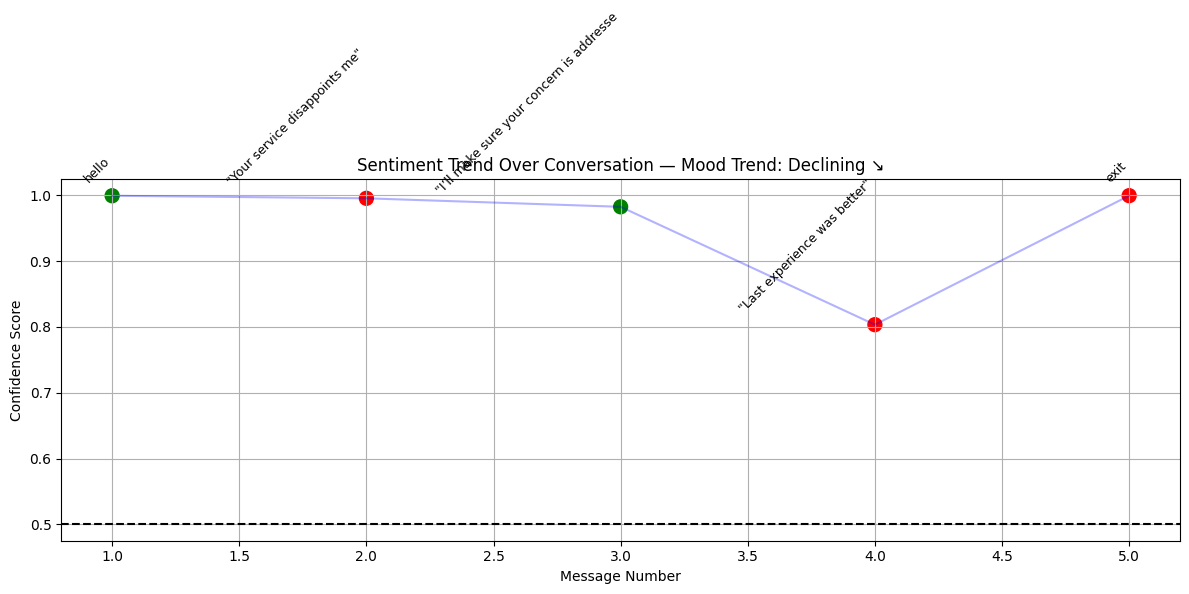

Sentiment trend chart saved as sentiment_trend.png


In [3]:
# ConvoSense - Chatbot + DistilBERT Sentiment Analysis + Trend Plot
!pip install transformers torch emoji matplotlib fpdf2

from transformers import pipeline
import matplotlib.pyplot as plt
import emoji
import numpy as np
from fpdf import FPDF

# --- Sentiment Pipeline ---
# Using DistilBERT fine-tuned on SST-2 for short-text sentiment
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Map POSITIVE/NEGATIVE to simpler labels, add Neutral if score ~0.5
def analyze_sentiment(text):
    result = sentiment_pipeline(text)[0]
    label = result['label']  # POSITIVE or NEGATIVE
    score = result['score']
    # Neutral if score close to 0.5
    if 0.45 <= score <= 0.55:
        label = "Neutral"
    elif label == "POSITIVE":
        label = "Positive"
    else:
        label = "Negative"
    return label, score

# --- Chatbot Responses ---
def chatbot_response(user_input):
    user_input = user_input.lower()
    if "hello" in user_input or "hi" in user_input:
        return "Hello! How can I help you today?"
    elif "help" in user_input:
        return "Sure, I'm here to assist you. What seems to be the issue?"
    elif "bye" in user_input or "exit" in user_input:
        return "Goodbye! Have a great day!"
    else:
        return "Thanks for sharing that. Tell me more."

# --- Overall sentiment from conversation ---
def overall_conversation_sentiment(history):
    combined = " ".join(history)
    label, _ = analyze_sentiment(combined)
    return label

# --- Mood trend detection ---
def mood_trend(scores):
    if len(scores) < 2:
        return "Stable"
    mid = len(scores) // 2
    first_half = np.mean(scores[:mid])
    second_half = np.mean(scores[mid:])
    if second_half > first_half + 0.05:
        return "Improving ↗️"
    elif second_half < first_half - 0.05:
        return "Declining ↘️"
    else:
        return "Stable →"

# --- Sentiment to emoji mapping ---
def sentiment_to_emoji(label):
    mapping = {'Positive':'🙂','Neutral':'😐','Negative':'🙁'}
    return mapping.get(label,'😐')

# --- Main chatbot loop ---
def run_chatbot():
    history = []
    labels = []
    scores = []
    user_messages = []

    print("=== Chatbot Started ===")
    print("Type 'exit' or 'bye' to end the chat.\n")

    while True:
        user_input = input("User: ")
        if user_input.lower() in ['exit', 'bye']:
            # analyze last message
            history.append(user_input)
            label, score = analyze_sentiment(user_input)
            labels.append(label)
            scores.append(score)
            user_messages.append(user_input)
            break

        # analyze sentiment
        history.append(user_input)
        label, score = analyze_sentiment(user_input)
        labels.append(label)
        scores.append(score)
        user_messages.append(user_input)
        print(f"→ Sentiment: {label} (score: {score:.2f})")

        # bot reply
        bot_reply = chatbot_response(user_input)
        print(f"Chatbot: {bot_reply}")
        history.append(bot_reply)

    # summary stats
    overall = overall_conversation_sentiment(history)
    trend = mood_trend(scores)

    print("\n=== Chat Summary ===")
    for msg, lab in zip(user_messages, labels):
        print(f"User: {msg} → Sentiment: {lab} {sentiment_to_emoji(lab)}")
    print(f"\nOverall conversation sentiment: {overall}")
    print(f"Conversation mood trend: {trend}")

    # --- Plot sentiment trend ---
    plt.figure(figsize=(12,6))
    color_map = {'Positive':'green','Neutral':'gray','Negative':'red'}
    colors = [color_map[l] for l in labels]
    x = range(1, len(scores)+1)
    plt.scatter(x, scores, c=colors, s=100)
    plt.plot(x, scores, linestyle='-', color='blue', alpha=0.3)
    # annotate messages
    for xi, yi, msg in zip(x, scores, user_messages):
        plt.text(xi, yi+0.02, msg[:40], rotation=45, ha='right', fontsize=9)
    plt.title(f"Sentiment Trend Over Conversation — Mood Trend: {trend}")
    plt.xlabel("Message Number")
    plt.ylabel("Confidence Score")
    plt.axhline(y=0.5, color='black', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plot_filename = "sentiment_trend.png"
    plt.savefig(plot_filename)
    plt.show()
    print(f"Sentiment trend chart saved as {plot_filename}")

# --- Run chatbot ---
if __name__ == "__main__":
    run_chatbot()
